In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold # import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score, accuracy_score
from sklearn.feature_selection import SelectFromModel

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

import yellowbrick as yb

### Predict Energy consumption

In [2]:
dataset = pd.read_csv('data1/dataset_seattle.csv')

In [3]:
dataset.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Cooling:Electricity [kW](Hourly)',
       'Date/Time', 'Electricity:Facility [kW](Hourly)',
       'Electricity:Facility [kW](Monthly)', 'Fans:Electricity [kW](Hourly)',
       'Gas:Facility [kW](Hourly)', 'Gas:Facility [kW](Monthly)',
       'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)',
       'InteriorEquipment:Gas [kW](Hourly)',
       'InteriorLights:Electricity [kW](Hourly)',
       'Water Heater:WaterSystems:Gas [kW](Hourly)', 'building_type',
       'location', 'location_id', 'building_id', 'Date', 'time', 'sunriseTime',
       'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
       'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
       'Presidents Day', 'Thanksgiving', 'Veterans Day', 'Day', 'is_weekend',
       'is_holiday', 'Holiday_name', 'day_of_week

In [4]:
dataset_numeric = dataset[['Cooling:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Fans:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Electricity [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'InteriorLights:Electricity [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)',
                           'location_id', 'building_id', 'time', 'sunriseTime',
                            'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew',
       'USA_WA_SEATTLE']]

In [5]:
dataset_numeric.describe()

,Cooling:Electricity [kW](Hourly),Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),InteriorEquipment:Gas [kW](Hourly),InteriorLights:Electricity [kW](Hourly),Water Heater:WaterSystems:Gas [kW](Hourly),...,RefBldgPrimarySchoolNew,RefBldgQuickServiceRestaurantNew,RefBldgSecondarySchoolNew,RefBldgSmallHotelNew,RefBldgSmallOfficeNew,RefBldgStand-aloneRetailNew,RefBldgStripMallNew,RefBldgSuperMarketNew,RefBldgWarehouseNew,USA_WA_SEATTLE
count,140160.000000,140160.000000,140160.000000,140160.000000,140160.000000,140160.000000,140160.000000,140160.000000,140160.000000,140160.000000,...,140160.000000,140160.000000,140160.000000,140160.000000,140160.000000,140160.000000,140160.000000,140160.000000,140160.000000,140160.0
mean,37.765751,180.211379,15.766441,103.491064,1.334908,74.122328,53.206147,10.160233,40.998511,19.208503,...,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,1.0
std,101.542688,288.624484,25.964042,191.655590,7.786216,169.274568,83.205118,18.416180,74.966520,59.009243,...,0.242062,0.242062,0.242062,0.242062,0.242062,0.242062,0.242062,0.242062,0.242062,0.0
min,0.000000,1.925019,0.000000,0.000000,0.000000,0.000000,1.011600,0.000000,0.275003,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,23.044088,0.253244,3.021100,0.000000,0.000000,8.089532,0.000000,3.788942,0.020000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,0.000000,55.575392,3.659254,26.933755,0.000000,6.468392,20.643869,2.653365,15.863942,1.738065,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,8.967271,192.986845,24.360913,101.010429,0.000000,67.421449,53.238744,9.905768,43.513342,10.994281,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
max,458.047681,1502.776534,156.696697,3150.315818,219.856108,3136.861981,448.566544,91.799800,448.566544,589.766774,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [9]:
corr_matrix = dataset_numeric.corr()
corr_matrix["Electricity:Facility [kW](Hourly)"].sort_values(ascending=False)

Electricity:Facility [kW](Hourly)             1.000000
InteriorEquipment:Electricity [kW](Hourly)    0.904150
Cooling:Electricity [kW](Hourly)              0.848468
Fans:Electricity [kW](Hourly)                 0.836380
InteriorLights:Electricity [kW](Hourly)       0.822422
RefBldgHospitalNew                            0.724358
Gas:Facility [kW](Hourly)                     0.572861
Heating:Gas [kW](Hourly)                      0.537586
InteriorEquipment:Gas [kW](Hourly)            0.442799
RefBldgLargeOfficeNew                         0.402856
Water Heater:WaterSystems:Gas [kW](Hourly)    0.180271
RefBldgSecondarySchoolNew                     0.080564
RefBldgLargeHotelNew                          0.072573
is_weekend                                    0.035337
temperatureHigh                               0.028337
Monday                                        0.026094
Tuesday                                       0.025227
Sunday                                        0.024997
dewPoint  

In [6]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
dataset_numeric_scaling = dataset_numeric[['Cooling:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Fans:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Electricity [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'InteriorLights:Electricity [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)', 'time', 'sunriseTime',
                            'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover']]
scaled_df = scaler.fit_transform(dataset_numeric_scaling)
scaled_df = pd.DataFrame(scaled_df, columns=['Cooling:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Fans:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Electricity [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'InteriorLights:Electricity [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)', 'time', 'sunriseTime',
                            'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover'])

one_hot_encoded_data = dataset_numeric[['Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew',
       'USA_WA_SEATTLE']]

In [7]:
processed_data = pd.concat((scaled_df, one_hot_encoded_data), axis=1)

In [8]:
processed_data.columns

Index(['Cooling:Electricity [kW](Hourly)', 'Electricity:Facility [kW](Hourly)',
       'Fans:Electricity [kW](Hourly)', 'Gas:Facility [kW](Hourly)',
       'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)',
       'InteriorEquipment:Gas [kW](Hourly)',
       'InteriorLights:Electricity [kW](Hourly)',
       'Water Heater:WaterSystems:Gas [kW](Hourly)', 'time', 'sunriseTime',
       'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
       'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
       'Presidents Day', 'Thanksgiving', 'Veterans Day', 'is_weekend',
       'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'Re

In [9]:
"""
dataset_features = processed_data[['Cooling:Electricity [kW](Hourly)',
                                    'Fans:Electricity [kW](Hourly)',
                                   'InteriorEquipment:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)',
                           'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew', 'USA_AK_FAIRBANKS',
       'USA_CA_LOS_ANGELES', 'USA_IL_CHICAGO-OHARE', 'USA_MN_MINNEAPOLIS',
       'USA_TX_HOUSTON', 'USA_WA_SEATTLE', 'USA_NV_LAS_VEGAS',
        'USA_CA_SAN_FRANCISCO', 'USA_AZ_PHOENIX', 'USA_GA_ATLANTA', 'USA_MD_BALTIMORE', 'USA_CO_BOULDER',
        'time', 'sunriseTime', 'sunsetTime']]
"""
dataset_features = processed_data[['Cooling:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)',
                           'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew',
       'USA_WA_SEATTLE',
        'time', 'sunriseTime', 'sunsetTime']]

dataset_labels = processed_data[['Electricity:Facility [kW](Hourly)']]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(dataset_features, dataset_labels, test_size=0.1)

In [11]:
model = LinearRegression()
est = model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print('Linear Regression model')
print('Mean Squared Error: %0.3f' % mse(expected, predicted))
print('Coefficient of Determination: %0.3f' % r2_score(expected, predicted))
print('Coefficients: {}'.format(model.coef_))

Linear Regression model
Mean Squared Error: 0.098
Coefficient of Determination: 0.901
Coefficients: [[ 6.11512194e-01  1.10712138e+09  3.31673149e-02 -9.77834743e+08
  -1.06383259e+08 -3.40873934e+08 -5.85267112e-03 -5.39553235e-03
  -1.11846785e-03 -1.69342756e-03 -1.07777119e-03 -1.77081330e-01
   5.67928143e-02 -1.85344530e-01  2.22311955e-02  4.66801682e-02
   1.44765154e-02 -2.63612503e-02  3.67632667e-02 -3.82334180e-03
   1.48554370e-02  2.39953958e+04 -3.40853548e-02 -3.08048337e+03
  -3.08032645e+03 -2.70757375e+04 -2.70757239e+04 -3.08046639e+03
  -3.08032846e+03 -3.08034648e+03  3.04363566e+03  3.04427857e+03
   3.04335839e+03  3.04544952e+03  3.04392306e+03  3.04378113e+03
   3.04396249e+03  3.04394265e+03  3.04366642e+03  3.04417410e+03
   3.04382926e+03  3.04375317e+03  3.04382645e+03  3.04381823e+03
   3.04424813e+03  3.04381120e+03  0.00000000e+00 -4.35100889e+00
   4.40856123e+00 -5.70415258e-02]]


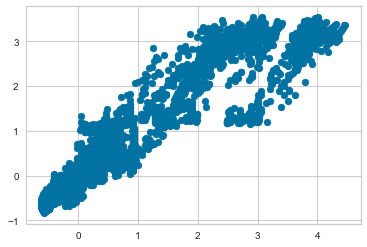

In [14]:
plt.scatter(y_test,predicted)

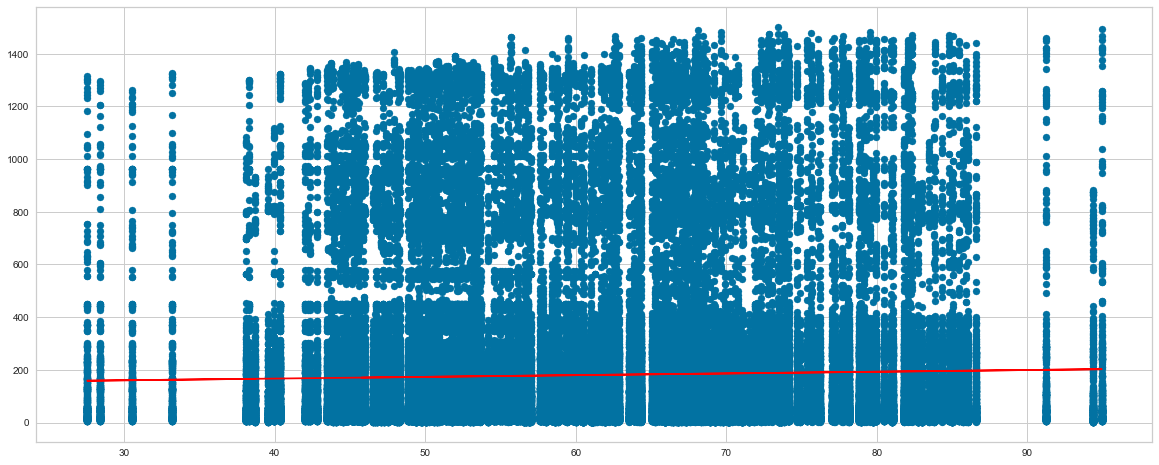

In [28]:
model = LinearRegression()
data = dataset_numeric[['temperatureHigh', 'Electricity:Facility [kW](Hourly)']]
X = data.iloc[:, 0].values.reshape(-1, 1)  # values converts it into a numpy array
Y = data.iloc[:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
model.fit(X,Y)
Y_pred = model.predict(X)  # make predictions

#print('Linear Regression model')
#print('Mean Squared Error: %0.3f' % mse(expected, predicted))
#print('Coefficient of Determination: %0.3f' % r2_score(expected, predicted))
plt.figure(figsize=(20, 8))
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

In [17]:
ridge = Ridge(alpha=1000)
ridge.fit(X_train, y_train)

expected = y_test
predicted = ridge.predict(X_test)

print('Ridge model')
print('Mean Squared Error: %0.3f' % mse(expected, predicted))
print('Coefficient of Determination: %0.3f' % r2_score(expected, predicted))

Ridge model
Mean Squared Error: 0.099
Coefficient of Determination: 0.900


In [18]:
regr_cv = RidgeCV(alphas=[0.5, 100, 1000])
regr_cv.fit(X_train, y_train)

expected = y_test
predicted = regr_cv.predict(X_test)

print('Ridge model')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Ridge model
Mean squared error = 0.095
R2 score = 0.904


In [19]:
regr_trans = TransformedTargetRegressor(regressor=RidgeCV(),
                                        func=np.log1p,
                                        inverse_func=np.expm1)
regr_trans.fit(X_train, y_train)
expected = y_test
predicted = regr_trans.predict(X_test)

print('Transformed target regressor')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Transformed target regressor
Mean squared error = 0.097
R2 score = 0.902


In [20]:
lasso = Lasso(alpha=0.2, max_iter=10e5)
lasso.fit(X_train,y_train)
expected = y_test
predicted = lasso.predict(X_test)

print('Lasso')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Lasso
Mean squared error = 0.302
R2 score = 0.695


## Feature Analysis and Selection

In [21]:
elastic = ElasticNet(alpha=0.15, max_iter=10e5)
elastic.fit(X_train,y_train)
expected = y_test
predicted = elastic.predict(X_test)

print('Elastic')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Elastic
Mean squared error = 0.253
R2 score = 0.745


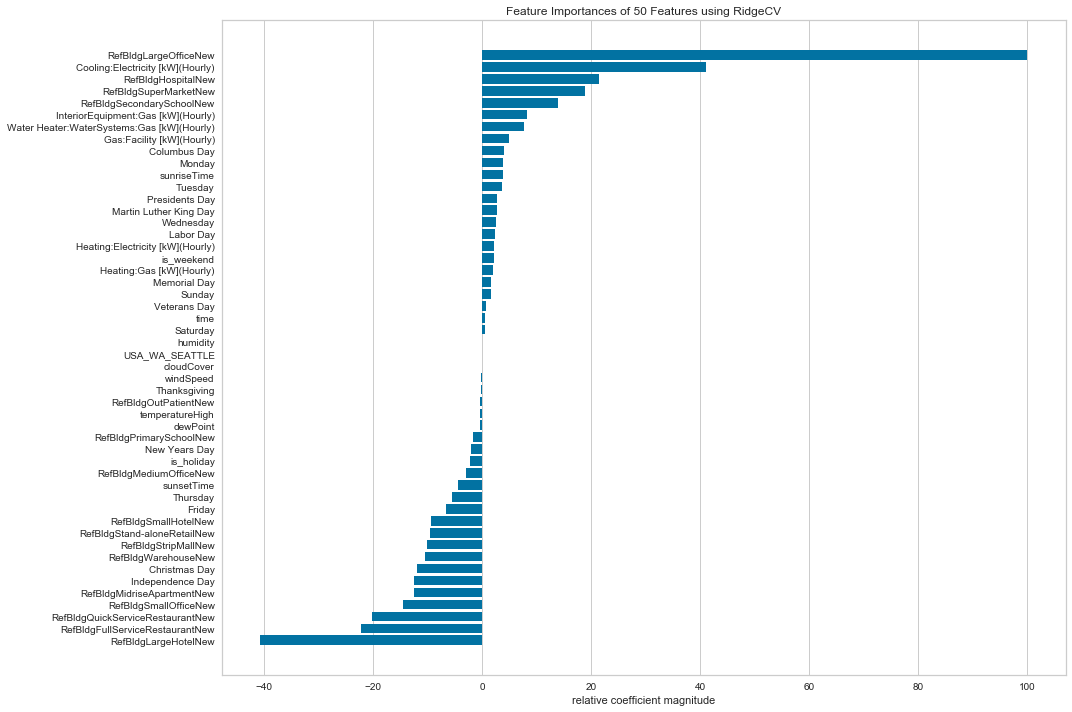

In [22]:
from yellowbrick.features import FeatureImportances

# model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(regr_cv, size=(1080, 720))

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

In [23]:
sfm = SelectFromModel(lasso)
sfm.fit(dataset_features, dataset_labels)
print(list(dataset_features.iloc[:, sfm.get_support(indices=True)]))

['Cooling:Electricity [kW](Hourly)', 'Gas:Facility [kW](Hourly)']


In [24]:
lasso.fit(dataset_features, dataset_labels)
print(list(zip(dataset_features, lasso.coef_.tolist())))

[('Cooling:Electricity [kW](Hourly)', 0.6190042293629885), ('Gas:Facility [kW](Hourly)', 0.05792393865030931), ('Heating:Electricity [kW](Hourly)', 0.0), ('Heating:Gas [kW](Hourly)', 0.0), ('InteriorEquipment:Gas [kW](Hourly)', 0.0), ('Water Heater:WaterSystems:Gas [kW](Hourly)', 0.0), ('temperatureHigh', -0.0), ('dewPoint', -0.0), ('humidity', 0.0), ('windSpeed', -0.0), ('cloudCover', 0.0), ('Christmas Day', -0.0), ('Columbus Day', 0.0), ('Independence Day', -0.0), ('Labor Day', 0.0), ('Martin Luther King Day', 0.0), ('Memorial Day', 0.0), ('New Years Day', -0.0), ('Presidents Day', 0.0), ('Thanksgiving', -0.0), ('Veterans Day', -0.0), ('is_weekend', 0.0), ('is_holiday', -0.0), ('Friday', -0.0), ('Monday', 0.0), ('Saturday', 0.0), ('Sunday', 0.0), ('Thursday', -0.0), ('Tuesday', 0.0), ('Wednesday', 0.0), ('RefBldgFullServiceRestaurantNew', -0.0), ('RefBldgHospitalNew', 0.0), ('RefBldgLargeHotelNew', -0.0), ('RefBldgLargeOfficeNew', 0.0), ('RefBldgMediumOfficeNew', -0.0), ('RefBldgMidr

In [25]:
# X_train, X_test, y_train, y_test = train_test_split(dataset_features, dataset_labels, test_size=0.01)
tscv = TimeSeriesSplit(n_splits=10)
#kf = KFold(n_splits=2, random_state=None, shuffle=False)
rmse = []
r2 = []
indices = []
for train_index, test_index in tscv.split(scaled_df):
    X_train, X_test = dataset_features.iloc[train_index], dataset_features.iloc[test_index]
    indices.append(train_index)
    y_train, y_test = dataset_labels.iloc[train_index], dataset_labels.iloc[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    expected = y_test
    predicted = model.predict(X_test)
    rmse.append(mse(expected, predicted))
    r2.append(r2_score(expected, predicted))
    
print('Linear Regression model')
print('Mean Squared Error: {}'.format(rmse))
print('Coefficient of Determination: {}'.format(r2))

Linear Regression model
Mean Squared Error: [1043217.5954997481, 0.19329797414796626, 0.10717471561307236, 1.9891706791804934e+17, 112905282011683.16, 0.09699779536247286, 2.0369574693250138e+17, 3.815549701479761e+16, 344390448347651.1, 5.3785390501886624e+17]
Coefficient of Determination: [-1195966.9075569974, 0.7852396175630569, 0.893270883473055, -1.7840947026692957e+17, -99448987815397.1, 0.9177031221065107, -1.7278165242647306e+17, -3.722391916853195e+16, -395953203423158.2, -6.263257322238556e+17]
